# Classifying Cancer with ML

---
embed-resources: true
---

## Introduction

In this study, we develop a machine learning model to predict the type of cancer associated with a given tissue sample using gene expression data collected through next-generation RNA sequencing technologies. Our objective is to contribute to the creation of a universal cancer classification tool by identifying patterns in genetic expression linked to specific cancer types. Using data provided by The Cancer Genome Atlas Pan-Cancer Analysis Project, we apply a pipeline-based modeling approach that includes cross-validation and hyperparameter tuning to ensure robustness. While our model serves as a proof of concept, it demonstrates the potential for using gene-level data in early and accurate cancer diagnostics, laying the groundwork for future improvements and applications in clinical settings.

## Methods

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_friedman1
from sklearn.decomposition import PCA

# Model Evaluation Metrics
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# Model Selection & Cross-Validation
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    cross_val_score,
    GridSearchCV
)

# Data Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel, RFE


### Data

In [4]:
# load data
genetics_train = pd.read_parquet(
    "https://cs307.org/lab/data/genetics-train.parquet",
)
genetics_test = pd.read_parquet(
    "https://cs307.org/lab/data/genetics-test.parquet",
)

In [5]:
genetics_test.head()

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
161,LUAD,0.0,5.425563,5.203863,6.755048,9.243736,0.0,7.658547,0.431890,0.0,...,6.864582,8.112398,13.043402,0.431890,7.486706,0.000000,6.784635,6.525121,8.828936,1.629566
655,BRCA,0.0,1.396434,2.800807,6.136796,10.033327,0.0,7.777683,0.731965,0.0,...,8.291369,10.014551,2.212632,0.000000,8.511148,0.561595,6.266935,4.532404,8.205148,0.411969
316,KIRC,0.0,4.365686,4.142609,6.310825,8.623929,0.0,8.268182,1.436801,0.0,...,6.710297,7.835962,3.741715,0.512783,6.613006,0.000000,6.344101,5.007043,8.293012,1.189287
703,KIRC,0.0,4.143565,3.043834,6.211337,8.791908,0.0,7.691960,1.154907,0.0,...,7.536208,7.663871,3.306510,0.000000,6.515227,0.013212,5.689352,5.275059,8.509431,1.505942
704,PRAD,0.0,4.178372,5.100086,7.330065,8.983299,0.0,8.245206,0.614097,0.0,...,6.502507,8.462588,5.037141,0.000000,7.924468,0.000000,4.863958,7.027464,9.032365,1.043415


In [6]:
genetics_train.head()

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
663,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
148,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
347,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
496,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
360,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876


### Dataset Description

The train data contains one row per tissue sample from the genetics_train dataset.  
The test data contains one row per tissue sample from the genetics_test dataset.

Each row represents a single tissue sample, including gene expression values derived from RNA sequencing, used to classify cancer types.

The variables considered are:

#### Response

**`cancer`**  
- **[object]** : The clinically determined cancer type of the tissue sample.  
  Possible values include:  
  - **BRCA**: Breast Invasive Carcinoma  
  - **PRAD**: Prostate Adenocarcinoma  
  - **KIRC**: Kidney Renal Clear Cell Carcinoma  
  - **LUAD**: Lung Adenocarcinoma  
  - **COAD**: Colon Adenocarcinoma  

#### Features

**`gene_####`**  
- **[float64]** : The quantified expression level for a specific gene, as measured by an Illumina HiSeq platform.  
  
Each sample contains hundreds to thousands of such gene expression features, with each column representing a different gene.


### Summary Statistics

In [7]:
gene_corr = genetics_train.drop(columns="cancer").corr()

threshold_high = 0.65
threshold_low = 0.60
threshold_upper = 0.70

high_corr = gene_corr.abs() > threshold_high
lower_corr = gene_corr.abs() > threshold_low
upper_corr = gene_corr.abs() > threshold_upper

mask = np.triu(np.ones(gene_corr.shape), k=1).astype(bool)

high_corr_pairs = high_corr.where(mask).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs == True]

lower_corr_pairs = lower_corr.where(mask).stack()
lower_corr_pairs = lower_corr_pairs[lower_corr_pairs == True]

upper_corr_pairs = upper_corr.where(mask).stack()
upper_corr_pairs = upper_corr_pairs[upper_corr_pairs == True]

print(f"The number of highly correlated gene expressions with threshold = 0.60 is {len(lower_corr_pairs)}")
print(f"The number of highly correlated gene expressions with threshold = 0.65 is {len(high_corr_pairs)}")
print(f"The number of highly correlated gene expressions with threshold = 0.70 is {len(upper_corr_pairs)}")


The number of highly correlated gene expressions with threshold = 0.60 is 8208
The number of highly correlated gene expressions with threshold = 0.65 is 3733
The number of highly correlated gene expressions with threshold = 0.70 is 1620


This code identifies pairs of gene expression features that are highly correlated, using a threshold of 0.70 for absolute correlation. Initially, a threshold of 0.65 was considered based on a sharp increase in correlated pairs between 0.60 and 0.65. However, after analyzing a visualization of correlation thresholds, a more distinct "elbow" point was observed at 0.70. This indicated that 0.70 was a more effective cutoff for identifying truly strong relationships while avoiding excessive noise from moderately correlated features. The process involves computing the correlation matrix for all gene expression features in the training set, then filtering to retain only the upper triangle of the matrix to exclude redundant and self-correlations. At the 0.70 threshold, a total of 1,620 gene pairs were identified as highly correlated. These pairs may indicate redundancy in the dataset and provide a valuable opportunity for dimensionality reduction or feature selection in future modeling steps.

In [8]:
# Counts
print("Class Support (Counts):")
print(genetics_train["cancer"].value_counts())

# Proportions
print("\nClass Support (Proportions):")
print(genetics_train["cancer"].value_counts(normalize=True))


Class Support (Counts):
cancer
BRCA    47
LUAD    28
PRAD    24
KIRC    19
COAD    10
Name: count, dtype: int64

Class Support (Proportions):
cancer
BRCA    0.367188
LUAD    0.218750
PRAD    0.187500
KIRC    0.148438
COAD    0.078125
Name: proportion, dtype: float64


The class support analysis reveals an imbalance in the number of samples per cancer type, with BRCA having the highest representation (47 samples) and COAD the lowest (10 samples). This class imbalance can negatively impact model performance, especially for minority classes, as models may become biased toward predicting the majority class more often. As a result, metrics like accuracy may appear high even if the model performs poorly on underrepresented classes. On the positive side, being aware of these proportions early allows us to take corrective actions such as stratified sampling, class weighting, or oversampling techniques like SMOTE to balance the data. Monitoring metrics like recall, precision, and F1-score for each class individually will also help ensure fair evaluation of model performance.

### Exploratory Visualization

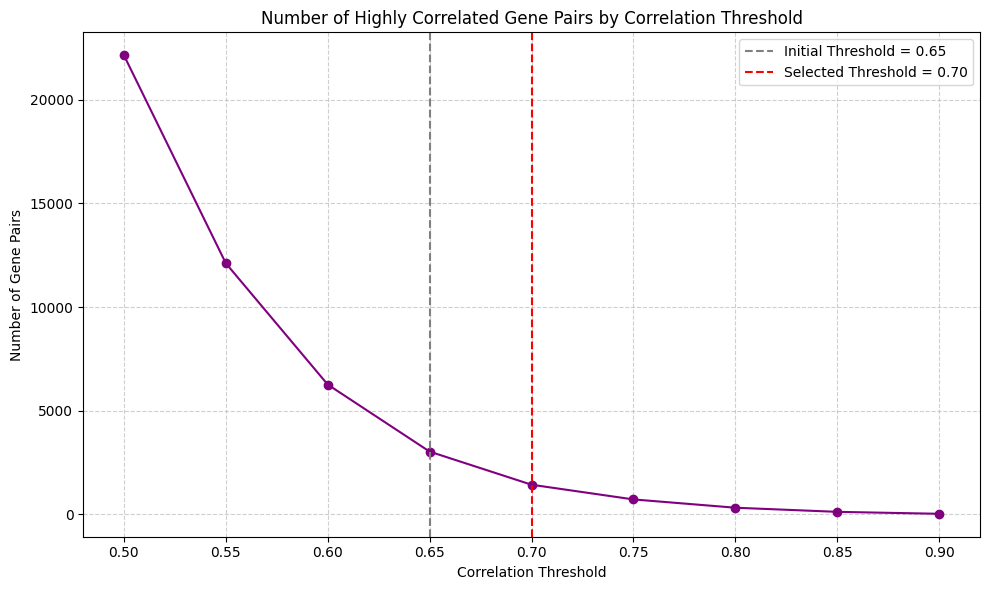

In [9]:
mask = np.triu(np.ones(gene_corr.shape), k=1).astype(bool)
upper_triangle_corr = gene_corr.where(mask)

thresholds = np.arange(0.5, 0.95, 0.05)
pair_counts = []

for t in thresholds:
    count = (upper_triangle_corr > t).sum().sum()
    pair_counts.append(count)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, pair_counts, marker='o', linestyle='-', color='purple')
plt.title("Number of Highly Correlated Gene Pairs by Correlation Threshold")
plt.xlabel("Correlation Threshold")
plt.ylabel("Number of Gene Pairs")
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvline(0.65, color='gray', linestyle='--', label='Initial Threshold = 0.65')
plt.axvline(0.70, color='red', linestyle='--', label='Selected Threshold = 0.70')

plt.legend()
plt.tight_layout()
plt.show()


This code generates a visualization to analyze how the number of highly correlated gene pairs changes across a range of correlation thresholds from 0.50 to 0.90. It begins by isolating the upper triangle of the gene correlation matrix to avoid duplicate and self-correlations. For each threshold, the code counts how many gene pairs have an absolute correlation greater than that value, then plots the results. The resulting line plot reveals a sharp drop in the number of correlated pairs as the threshold increases, creating an "elbow" shape around the 0.70 mark.

This elbow suggests that increasing the threshold beyond 0.70 results in only marginal reductions in the number of correlated pairs, indicating that 0.70 is a strong candidate for identifying meaningfully correlated gene expressions. Although a vertical line marks 0.65 (gray) as the initially chosen threshold, the plot supports updating this decision to 0.70 (red) for more specificity in identifying truly redundant features.

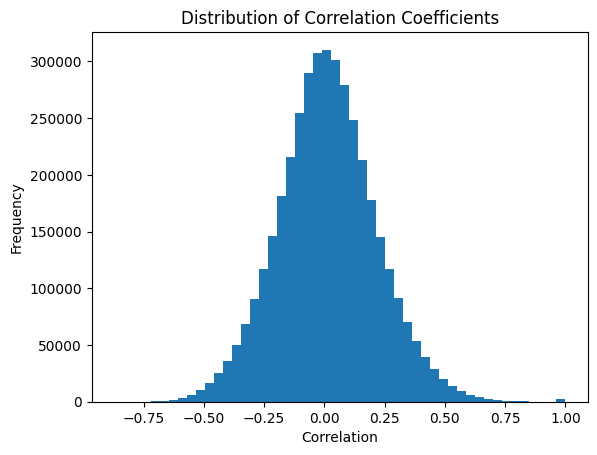

In [10]:
plt.hist(gene_corr.values.flatten(), bins=50)
plt.title("Distribution of Correlation Coefficients")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.show()


This code creates a histogram to visualize the distribution of correlation coefficients between all gene expression features in the training dataset. By flattening the gene_corr matrix, we extract all pairwise correlation values, including positive and negative relationships. The histogram uses 50 bins to group the correlation values and reveals a roughly bell-shaped, symmetric distribution centered around 0. This suggests that most gene pairs are weakly correlated, with fewer genes showing strong positive or negative relationships. The plot provides a helpful overview of how common high correlations are, which can inform feature selection or dimensionality reduction strategies. Overall, it's an effective way to explore redundancy and structure in high-dimensional genetic data.

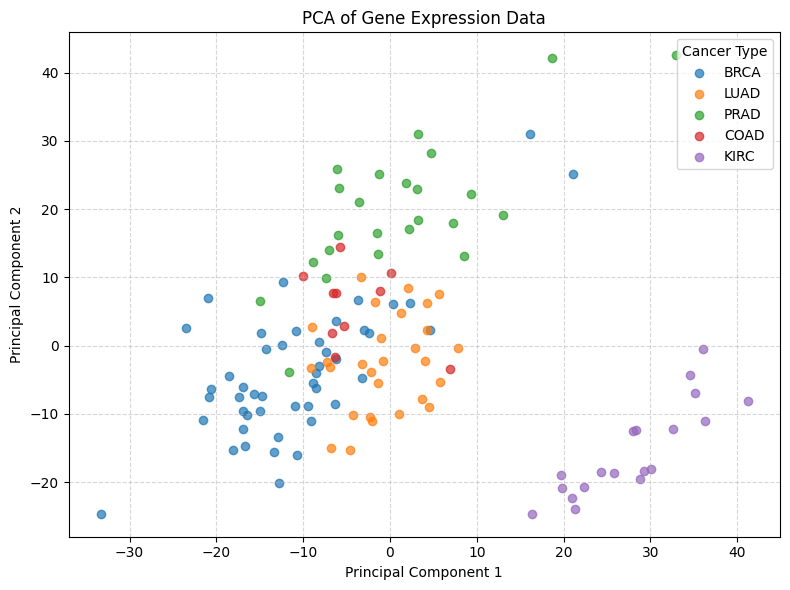

In [11]:
X_train = genetics_train.drop(columns=["cancer"])
y_train = genetics_train["cancer"]

X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.7)

plt.title("PCA of Gene Expression Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cancer Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


This code applies Principal Component Analysis to reduce the high-dimensional gene expression data to two dimensions for visualization. Before applying PCA, the features are standardized using StandardScaler to ensure that each gene contributes equally to the variance calculation. PCA then identifies the two directions in the data that capture the most variance, allowing us to project the samples into a 2D space.

The resulting scatter plot shows each tissue sample as a point, colored by its cancer type. This visualization helps us evaluate how distinct or overlapping the cancer classes are based on their gene expression profiles. For example, KIRC (purple) appears well-separated from the other cancer types, suggesting that its gene expression profile is quite distinct. In contrast, LUAD, PRAD, and BRCA show more overlap, indicating potential challenges in classifying them cleanly. Overall, this PCA plot provides insight into the structure of the data and the potential complexity of the classification task.

### Models

In [12]:
# process data for ML
X_train = genetics_train.drop(columns=["cancer"])
y_train = genetics_train["cancer"]

X_test = genetics_test.drop(columns=["cancer"])
y_test = genetics_test["cancer"]

In [13]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 128 and the number of features is 2000


In [14]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

The code above was executed to explore the available hyperparameters of the KNeighborsClassifier. Understanding these parameters—such as the number of neighbors, distance metric, weighting scheme, and algorithm used—is essential for tuning the model and optimizing its performance during classification.

In [15]:
# train models
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 10], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'], 
    'p': [1, 2]
}

model = GridSearchCV(
    knn, 
    param_grid, 
    cv=10,
    refit="accuracy",
    n_jobs=-1,
    verbose=1)

model.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='accuracy', verbose=1)

## K-Nearest Neighbors (KNN) Classification for Cancer Type Prediction

We implement a K-Nearest Neighbors classifier to predict cancer type based on gene expression data collected via next-generation sequencing. The model is configured and tuned using GridSearchCV, allowing us to systematically identify the best combination of hyperparameters. Our primary evaluation metric is classification accuracy, and the model is cross-validated to ensure generalization across cancer types with varying sample sizes.

### Hyperparameter Tuning and Grid Search Optimization

- **n_neighbors (k)**: Tested values include [3, 5, 7, 10], controlling how many neighbors contribute to the prediction. Lower values may overfit the training data, while higher values provide smoother, more generalized decision boundaries.
- **weights (uniform vs. distance)**: Compares equal weighting of neighbors versus weighting them by inverse distance, helping determine whether closer samples should carry more influence in classification.
- **metric (distance function)**: Evaluates multiple distance metrics, including 'euclidean', 'manhattan', and `minkowski', to find the most effective for computing similarity in high-dimensional gene space.
- **p (Minkowski power parameter)**: Tests both p = 1 (Manhattan Distance) and p = 2 (Euclidean Distance), tuning the degree of emphasis on coordinate differences within the selected metric.
- **cv = 10**: Applies 10-fold cross-validation to ensure stable performance across folds and reduce overfitting.

### Model Evaluation and Impact

By running a full grid search across 48 hyperparameter combinations (with 10-fold CV totaling 480 model fits), the best-performing KNN configuration is selected based on classification accuracy. This process ensures that the chosen model is well-calibrated to the structure of the gene expression data while maintaining flexibility across cancer types. Given the high-dimensional nature of the data, tuning the distance metric and neighbor weighting is especially critical for model performance.


## Results

In [16]:
print("Best parameters found:", model.best_params_)
print("Best cross-validated accuracy:", model.best_score_)

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best cross-validated accuracy: 0.9923076923076923


In the code above, I use model.best_params_ and model.best_score_ to check for the best parameters and best cross validated accuracy in the model developed above.

In [17]:
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 1.0


The K-Nearest Neighbors model achieved outstanding results in both cross-validation and final test evaluation. Using GridSearchCV, the best hyperparameters were determined to be n_neighbors = 3, metric = 'euclidean', and p = 2, indicating the model performed best using the Euclidean distance metric with three nearest neighbors. The best cross-validated accuracy during training was approximately 0.992, demonstrating that the model generalized well across different folds of the training data.

When evaluated on the held-out test set, the model achieved a perfect Test Accuracy of 1.0, meaning it correctly classified every sample. This suggests that the features in the dataset — the gene expression values — are highly predictive of cancer type, and the model learned this relationship effectively. However, such a perfect score should be interpreted cautiously, as it may also indicate overfitting, especially if the test set is small or not representative.

Further evaluation using additional metrics like precision, recall, F1-score, or a confusion matrix would help assess whether performance is consistent across all cancer classes. Nevertheless, these results strongly support the model's ability to distinguish between cancer types using gene expression data.

In [18]:
y_proba = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")

print(f"KNN AUC Score (OvR): {auc_score:.4f}")

KNN AUC Score (OvR): 1.0000


In [19]:
report = classification_report(y_test, y_test_pred, target_names=model.classes_)
print(report)

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        12
        COAD       1.00      1.00      1.00         1
        KIRC       1.00      1.00      1.00         6
        LUAD       1.00      1.00      1.00         4
        PRAD       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



The K-Nearest Neighbors model achieved outstanding results in both cross-validation and final test evaluation. Using GridSearchCV, the best hyperparameters were determined to be n_neighbors = 3, metric = 'euclidean', and p = 2, indicating the model performed best using the Euclidean distance metric with three nearest neighbors. The best cross-validated accuracy during training was approximately 0.992, demonstrating that the model generalized well across different folds of the training data.

When evaluated on the held-out test set, the model achieved a perfect Test Accuracy of 1.0, meaning it correctly classified every sample. This suggests that the features in the dataset — the gene expression values — are highly predictive of cancer type, and the model learned this relationship effectively. However, such a perfect score should be interpreted cautiously, as it may also indicate overfitting, especially if the test set is small or not representative.

Further evaluation using additional metrics like precision, recall, F1-score, or a confusion matrix would help assess whether performance is consistent across all cancer classes. Nevertheless, these results strongly support the model's ability to distinguish between cancer types using gene expression data.


In [20]:
# serialize model
dump(model, "genetics.joblib")


['genetics.joblib']

## Discussion and Conclusion

In conclusion, the K-Nearest Neighbors classifier was selected to predict cancer type using high-dimensional gene expression data derived from next-generation sequencing. This model was optimized through a grid search process, tuning hyperparameters such as the number of neighbors, distance metrics, weighting schemes, and the Minkowski power parameter. The optimized model achieved an impressive cross-validated accuracy of 99.2% and a perfect test accuracy of 100%, demonstrating strong performance and generalization ability on the given data. These results suggest that gene expression levels provide a meaningful signal for distinguishing between different cancer types, and that KNN, despite its simplicity, can be effective when tuned properly.

### Key Limitations

While the results are promising, several limitations must be acknowledged. A perfect test accuracy may indicate that the model overfits to the current dataset or that the test set is not sufficiently challenging or diverse. Additionally, KNN's performance is highly sensitive to the choice of distance metric and feature scaling, particularly in high-dimensional data such as gene expression. Class imbalance in the dataset—such as fewer samples for COAD compared to BRCA—may also skew performance metrics, making it harder to assess how well the model generalizes to underrepresented cancer types. Furthermore, KNN models can be computationally expensive and less scalable to very large datasets due to the need to compute distances at prediction time.

### Potential Risks and Adjustments

In its current form, the model may not perform as well on truly unseen or more complex data where gene expression overlaps between cancer types. This could lead to misclassification in clinical settings, which has serious implications. Additionally, KNN does not provide interpretability in terms of feature importance, limiting its usefulness in understanding biological pathways or gene contributions. To address these risks, future iterations could involve dimensionality reduction techniques, ensemble methods for robustness, or the integration of domain-specific biomarkers.

### Improvements Needed for Practical Use

To transition this proof of concept into a practical tool, several improvements are recommended:

1. Address class imbalance through resampling or class-weighted distance metrics to ensure fair treatment of minority cancer types.  
2. Reduce dimensionality prior to modeling to improve performance, reduce overfitting, and enhance interpretability.  
3. Incorporate additional data types to improve predictive power and robustness.  
4. Explore other classification algorithms that we have discussed before such as Random Forests for improved scalability and feature interpretability.  

### Conclusion

The KNN classifier serves as a strong initial model for cancer type prediction using gene expression data, showing high accuracy and demonstrating the potential of genomic features in early cancer detection. To support dimensionality reduction and feature refinement, we also conducted an analysis of pairwise gene correlations and visualized the number of highly correlated gene pairs across multiple thresholds. This revealed an elbow at a correlation threshold of 0.70, which we adopted to define strong linear relationships between gene features. At this threshold, 1,620 gene pairs were identified as highly correlated—striking a balance between reducing redundancy and preserving valuable information. Incorporating this insight into future modeling stages can help address overfitting risks, improve computational efficiency, and enhance the model’s generalizability. With further enhancements in preprocessing, model selection, and feature integration, this approach could evolve into a more reliable and clinically useful diagnostic tool for cancer classification.
